## Homework 3

### Classification
1. Implement k-fold test/train split
2. Classify over iris, vowel and south africa datasets
3. Generate a gaussian-distributed synthetic dataset(2 dimensional)
3. Plot boundaries of classifier
4. Add quadratic features as well

Do this for both linear classification and linear discriminant anaylsis

In [1]:
%matplotlib inline
# standard library
import itertools

# pandas
import pandas as pd

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.datasets

# this styling is purely my preference
# less chartjunk
sns.set_context('notebook', font_scale=1.5, rc={'line.linewidth': 2.5})
sns.set(style='ticks', palette='Set2')

In [2]:
def pad_design_matrix(X):
    """Return the design matrix padded with 
    the constant feature"""
    aux = np.ones((X.shape[0], X.shape[1]+1))
    aux[:, 1:] = X
    return aux

def ordinary_least_squares(X, Y, l=0):
    """Return the best coefficients using OLS
    Does ridge regression if lambda is specified"""
    # the design matrix has the vectors 
    # as rows instead of cols
    X_pad = pad_design_matrix(X)
    
    # add the regularization term. unaffected if 0
    inv = np.linalg.inv(X_pad.T.dot(X_pad) + l * np.eye(X_pad.shape[1]))
    return inv.dot(X_pad.T.dot(Y))

def mse(X, beta, Y):
    # mean squared error
    return np.mean((pad_design_matrix(X).dot(beta) - Y).ravel() ** 2)

In [3]:
def k_fold_split(X, Y, k=5):
    """Yields all fold splits of the train data as
    (X_train, Y_train, X_test, Y_test). Defaults to
    80/20 split(aka. 5 folds)."""
    splits = np.linspace(0, X.shape[0], k+1).astype(int)
    intervals = zip(splits[:-1], splits[1:])  # the intervals for the test data
    
    for start, stop in intervals:
        # the training set is the entire set excluding test
        X_train = np.vstack([X[:start], X[stop:]])
        Y_train = np.vstack([Y[:start], Y[stop:]])
        X_test = X[start:stop]
        Y_test = Y[start:stop]
        yield (X_train, Y_train, X_test, Y_test)
        
def one_hot_encode(labels):
    """Returns the one-hot encoded matrix of 
    the features"""
    label_set = set(labels)
    label_mapping = {label: num for num, label in enumerate(label_set)}
    rows = []  # the rows of the new matrix
    for label in labels:
        # compute the row to add
        if len(label_set) == 2:
            # in case there are only two albels
            # use a single column
            row = np.array([float(label == list(label_set)[0])])  
        else:
            # for more than two, do proper one-hot
            pos = label_mapping[label]
            row = np.zeros(len(label_set))
            row[pos] = 1
            
        rows.append(row)
    
    return np.vstack(rows)

In [4]:
def k_fold_linear_class_err(X, Y, k=5):
    """Returns the train and test error using kfolds"""
    train_errs = []
    test_errs = []
    Y = one_hot_encode(Y)  # features must be encoded

    for X_train, Y_train, X_test, Y_test in k_fold_split(X, Y, k):

        beta = ordinary_least_squares(X_train, Y_train)
        # append the train and test errors
        train_errs.append(mse(X_train, beta, Y_train))
        test_errs.append(mse(X_test, beta, Y_test))

    return np.mean(train_errs), np.mean(test_errs)


def generate_dataset(size, dim=2, classes=3):
    """Generate a synthetic dataset with a given
    number of classes. The classes have points in a 
    gaussian distribution around uniformly distributed
    centroids"""
    # get the centroids of the classes
    centroids = np.random.uniform(size=(classes, dim), low=0.2, high=0.8)
   
    X_rows = []
    Y_rows = []
    for _ in range(size):
        noise = np.random.normal(size=(classes, dim), scale=0.04)
        # add gaussian noise to the centroids to get samples
        X_rows.append(centroids + noise)
        Y_rows.append(np.arange(classes))

    # stack the X and Y
    return np.vstack(X_rows), np.hstack(Y_rows)

In [166]:
# map the datasets and train agianst them
DATASETS = {}

# iris
iris_ds =  sklearn.datasets.load_iris()
DATASETS['iris'] = {
    'X': iris_ds['data'],
    'Y': iris_ds['target']
}

# south african heart disease
south_africa_ds = pd.read_csv('https://raw.githubusercontent.com/awesome-spark/learn-by-examples/master/scoring-heart-disease/data/SAheart.data.txt')
south_africa_ds['famhist'] = south_africa_ds['famhist'] == 'Present'
DATASETS['south_africa'] = {
    'X': south_africa_ds.drop('chd', axis='columns').values,
    'Y': south_africa_ds['chd'].values
}

# vowel
synth_ds = generate_dataset(1000, dim=10, classes=5)
DATASETS['synthetic'] = {
    'X': synth_ds[0],
    'Y': synth_ds[1]
}

print('LINEAR MODEL\n' + '=' * 40)
# predict over the datasets
for name, dataset in DATASETS.items():
    X, Y = dataset['X'], dataset['Y']
    train_err, test_err = k_fold_linear_class_err(X, Y)
    print(name)
    print('TRAIN ERROR: {}\n TEST ERROR: {}\n'.format(train_err, test_err))

LINEAR MODEL
iris
TRAIN ERROR: 0.08445843702868745
 TEST ERROR: 0.15131856728322443

south_africa
TRAIN ERROR: 0.17141918167417666
 TEST ERROR: 0.18264099641190726

synthetic
TRAIN ERROR: 0.006557937023777037
 TEST ERROR: 0.006588219775119678



In [252]:
def plot_boundaries(X, Y, beta, quadratic=False):
    """Plot a 2-dimensional dataset and the class
    boundaries according to the given betas."""
    for cls in set(Y):
        plt.scatter(X[Y == cls].T[0], X[Y == cls].T[1])

    # get pairs of betas
    for row1, row2 in itertools.combinations(list(beta.T), 2):
        X1 = np.linspace(0, 1, 1000)
        diff = row1- row2

        # different equations for quadratics
        if quadratic:
            X2 = (diff[0] + diff[1] * X1) / (-diff[2] - diff[3] * X1)
            # add the discontinuities 
            disc_X1 = -diff[2] / diff[3]
            
            X1 = np.append(X1, disc_X1)
            X2 = np.append(X2, np.nan)
            
            # insert the discontinuity and sort
            plot_vals = np.vstack([X1, X2])
            i = np.argsort(X1)
            plot_vals = plot_vals[:, i]
            X1, X2 = list(plot_vals)  # list-unwrapping
        else:
            X2 = (diff[0] + diff[1] * X1) / -diff[2]
        plt.plot(X1, X2)  # distinct color
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    sns.despine()

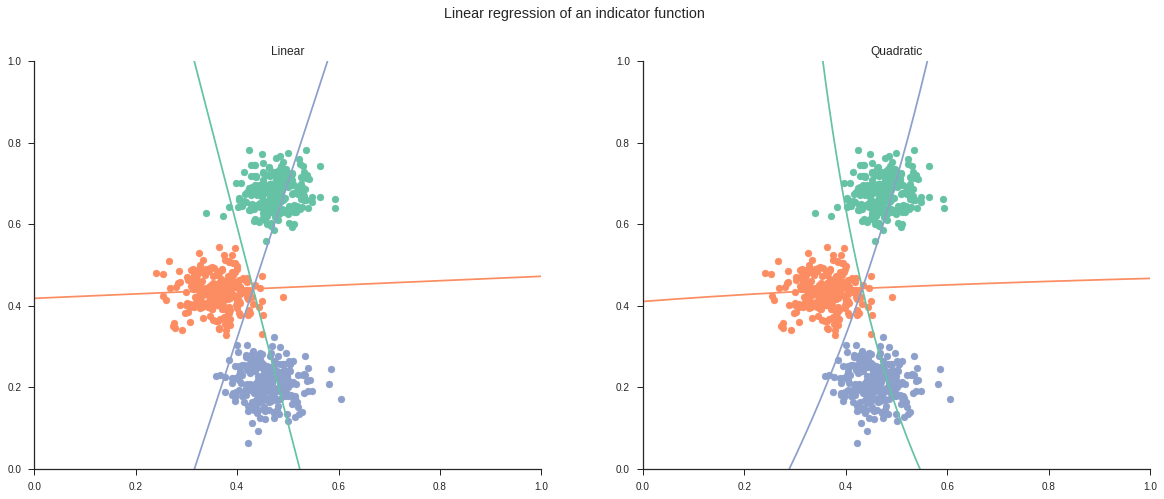

In [336]:
# plot the linear boundaries
X, Y = generate_dataset(250, classes=3)

fig = plt.figure(figsize=(20, 7.5))
fig.suptitle('Linear regression of an indicator function')

beta = ordinary_least_squares(X, one_hot_encode(Y))
plt.subplot(121)
plot_boundaries(X, Y, beta)
plt.title('Linear')

# plot with quadratic model

quad_X = np.hstack([X, (X[:, 0] * X[:, 1])[:, np.newaxis]])
beta = ordinary_least_squares(quad_X, one_hot_encode(Y))
plt.subplot(122)
plot_boundaries(X, Y, beta, True)
plt.title('Quadratic')

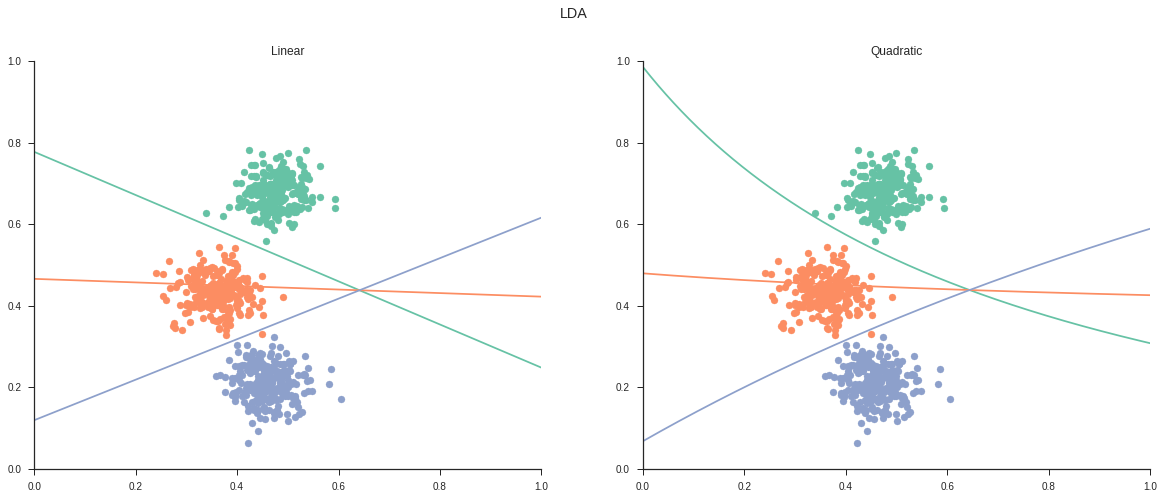

In [339]:
def lda(X, Y):
    """Returns the linear coefficients of the bondaries for
    linear discriminant analysis."""
    class_probs = Y.sum(axis=0) / Y.shape[0]
    centroids = np.vstack([X[Y[:, cls] == 1].mean(axis=0) 
                           for cls in range(Y.shape[1])])
    # compute te covariance matrix
    centr_dist = np.vstack([X[Y[:, cls] == 1] - centroids[cls]
                           for cls in range(Y.shape[1])])
    # make it unbiased
    covar = centr_dist.T.dot(centr_dist) / (Y.shape[0] - Y.shape[1])
    
    # compute the params
    covar_inv = np.linalg.inv(covar)
    beta = covar_inv.dot(centroids.T).T
    intercepts = -0.5 * np.array([centroid.dot(covar_inv).dot(centroid.T) 
                                 for centroid in list(centroids)])
    
    # return beta transpose
    return np.hstack([intercepts[:, np.newaxis], beta]).T
    
fig = plt.figure(figsize=(20, 7.5))
fig.suptitle('LDA')
    
beta = lda(X, one_hot_encode(Y))
plt.subplot(121)
plot_boundaries(X, Y, beta, False)
plt.title('Linear')

beta = lda(quad_X, one_hot_encode(Y))
plt.subplot(122)
plot_boundaries(X, Y, beta, True)
plt.title('Quadratic')

In [ ]:
 logistic_regression(X, Y):